In [1]:
%matplotlib inline
import numpy as np
import pystan
import matplotlib.pylab as plt

%config InlineBackend.figure_format = 'retina'

In [2]:
plt.rcParams["figure.figsize"] = (20,6)

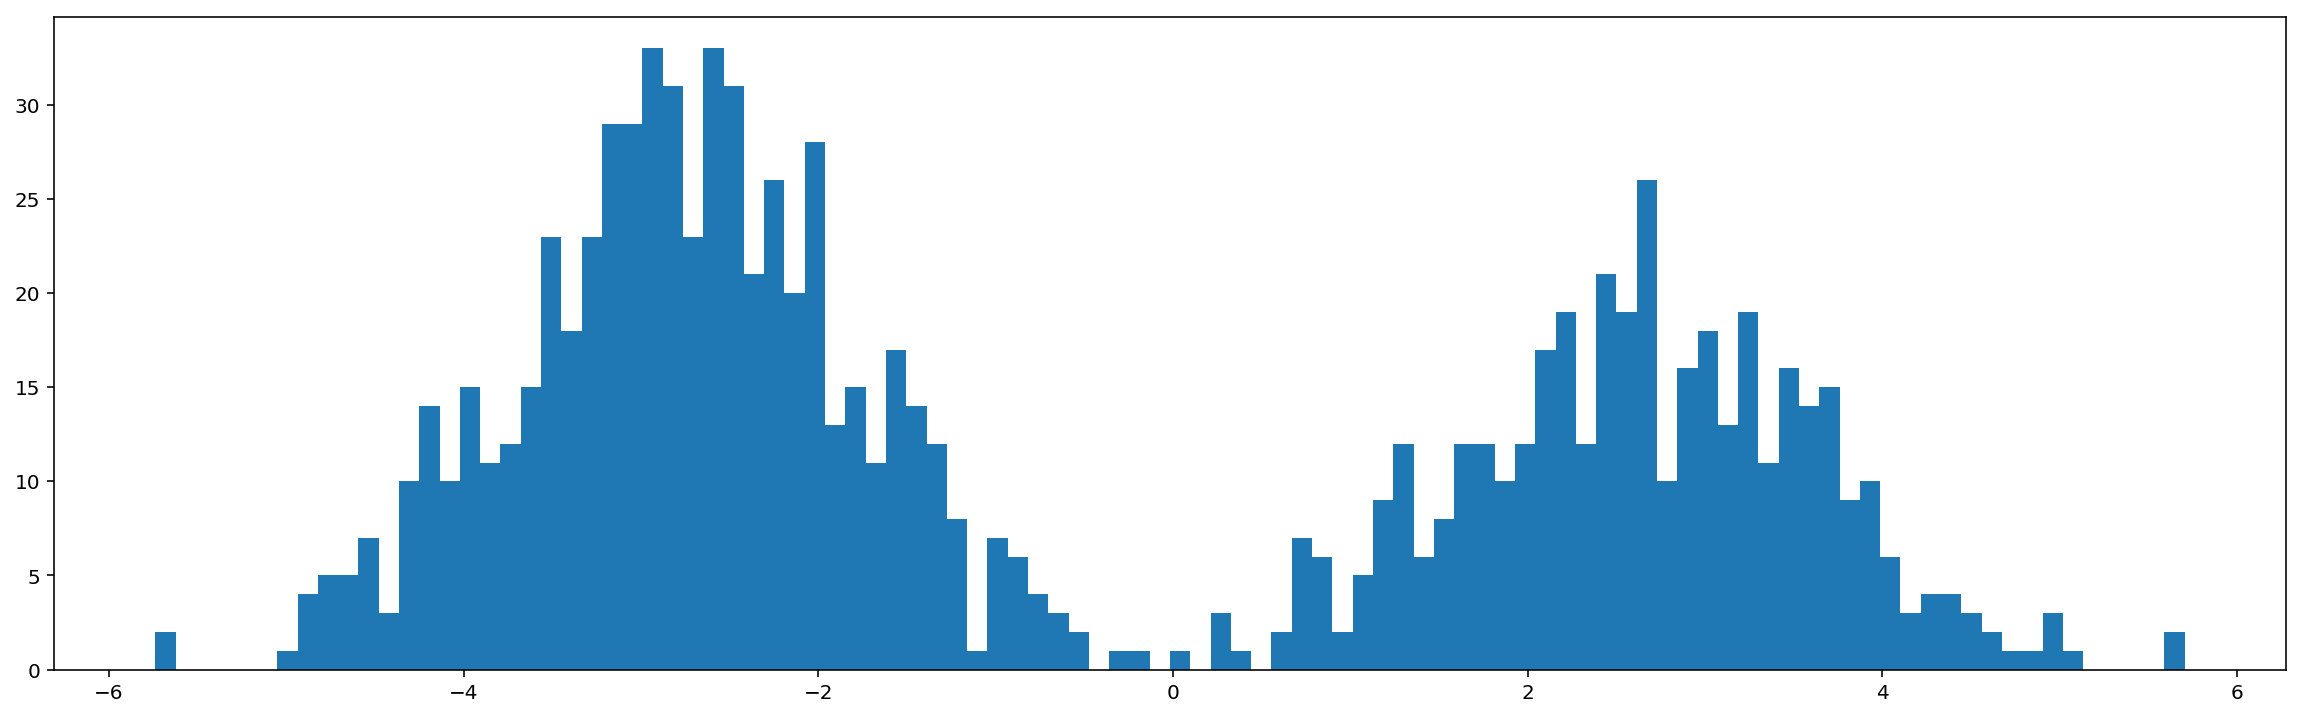

In [3]:
mu0 = np.asarray([-2.75, 2.75])
sigma0 = np.asarray([1, 1])
lam = 0.4

N = 1000
z = np.random.binomial(1, lam, size=(N,))
y = np.random.normal(loc=mu0[z], scale=sigma0[z])

plt.hist(y, 100);

## θ ~ Beta(5, 5)

In [4]:
model = """
data {
 int<lower = 0> N;
 vector[N] y;
}

parameters {
  ordered[2] mu;
  real<lower=0> sigma[2];
  real<lower=0, upper=1> theta;
}

model {
 sigma ~ normal(0, 2);
 mu ~ normal(0, 2);
 theta ~ beta(5, 5);
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4a1a8842066ad04ed5bb50ec34a6de05 NOW.


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_4a1a8842066ad04ed5bb50ec34a6de05.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     -2.76  8.6e-4   0.04  -2.83  -2.78  -2.76  -2.73  -2.68   2000    1.0
mu[1]      2.63  1.1e-3   0.05   2.53    2.6   2.63   2.67   2.73   2000    1.0
sigma[0]   0.95  6.6e-4   0.03   0.89   0.93   0.95   0.97   1.01   2000    1.0
sigma[1]   1.01  8.5e-4   0.04   0.93   0.98    1.0   1.03   1.08   2000    1.0
theta       0.6  3.4e-4   0.02   0.57   0.59    0.6   0.61   0.63   2000    1.0
lp__      -2065    0.05   1.57  -2069  -2066  -2065  -2064  -2063    860    1.0

Samples were drawn using NUTS at Fri Aug 17 17:42:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


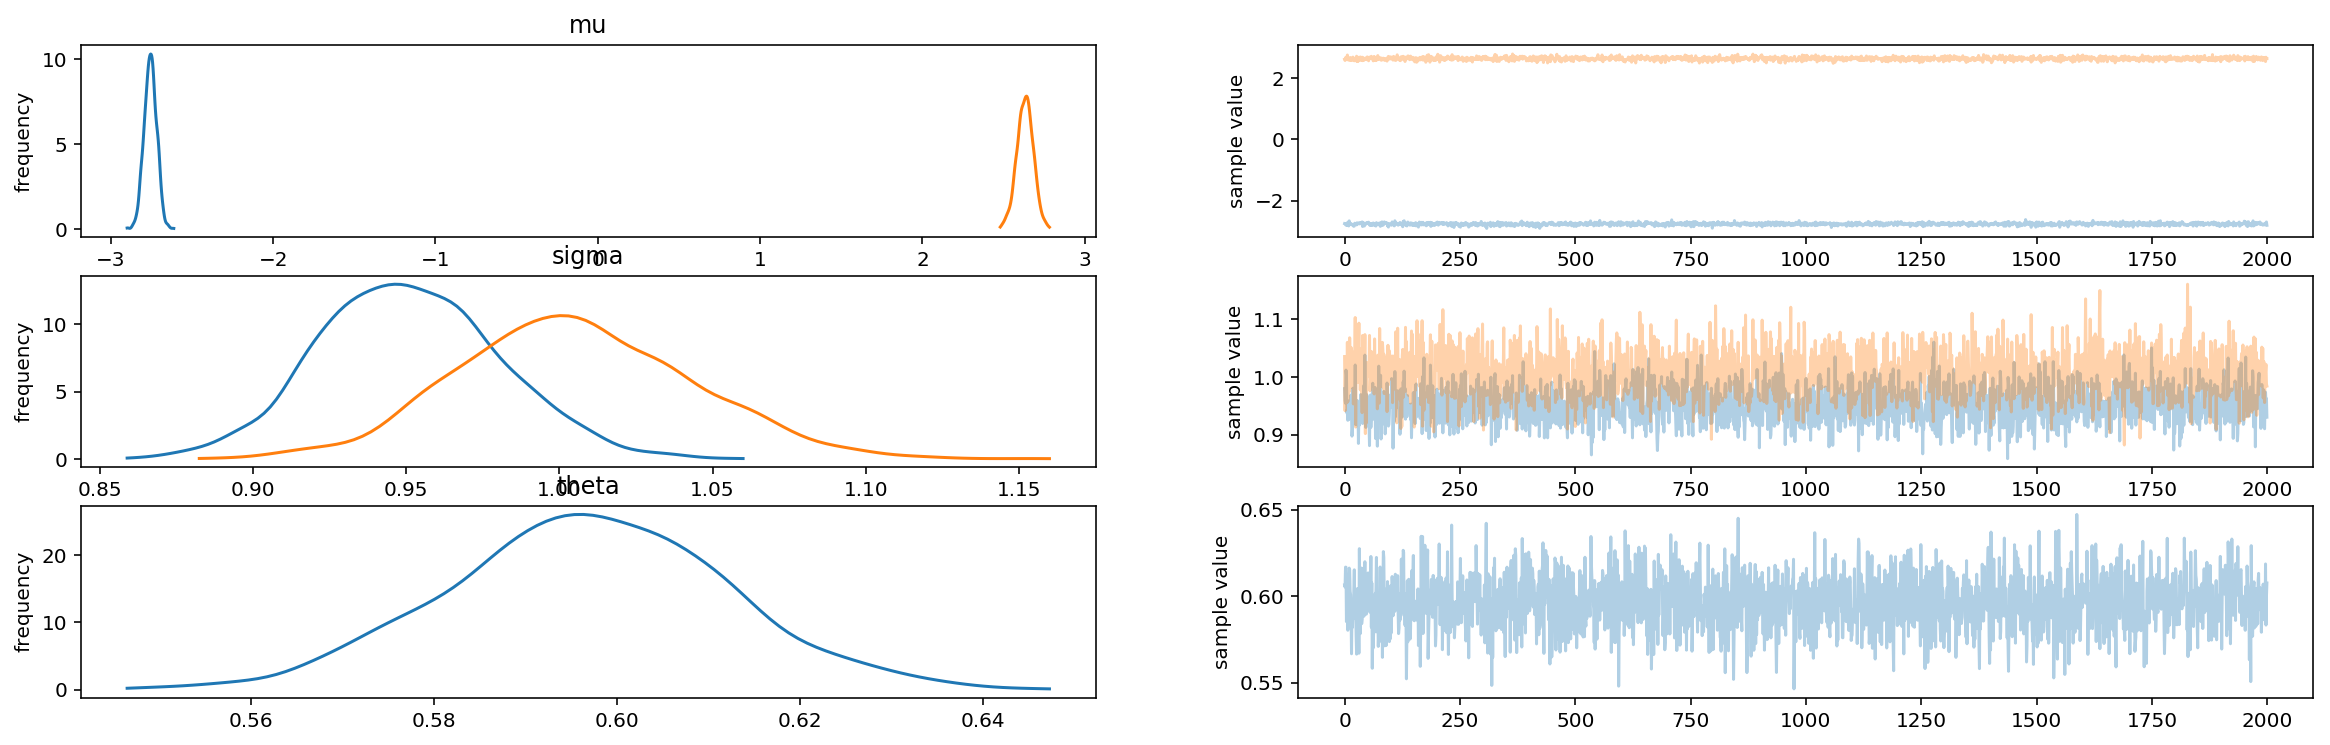

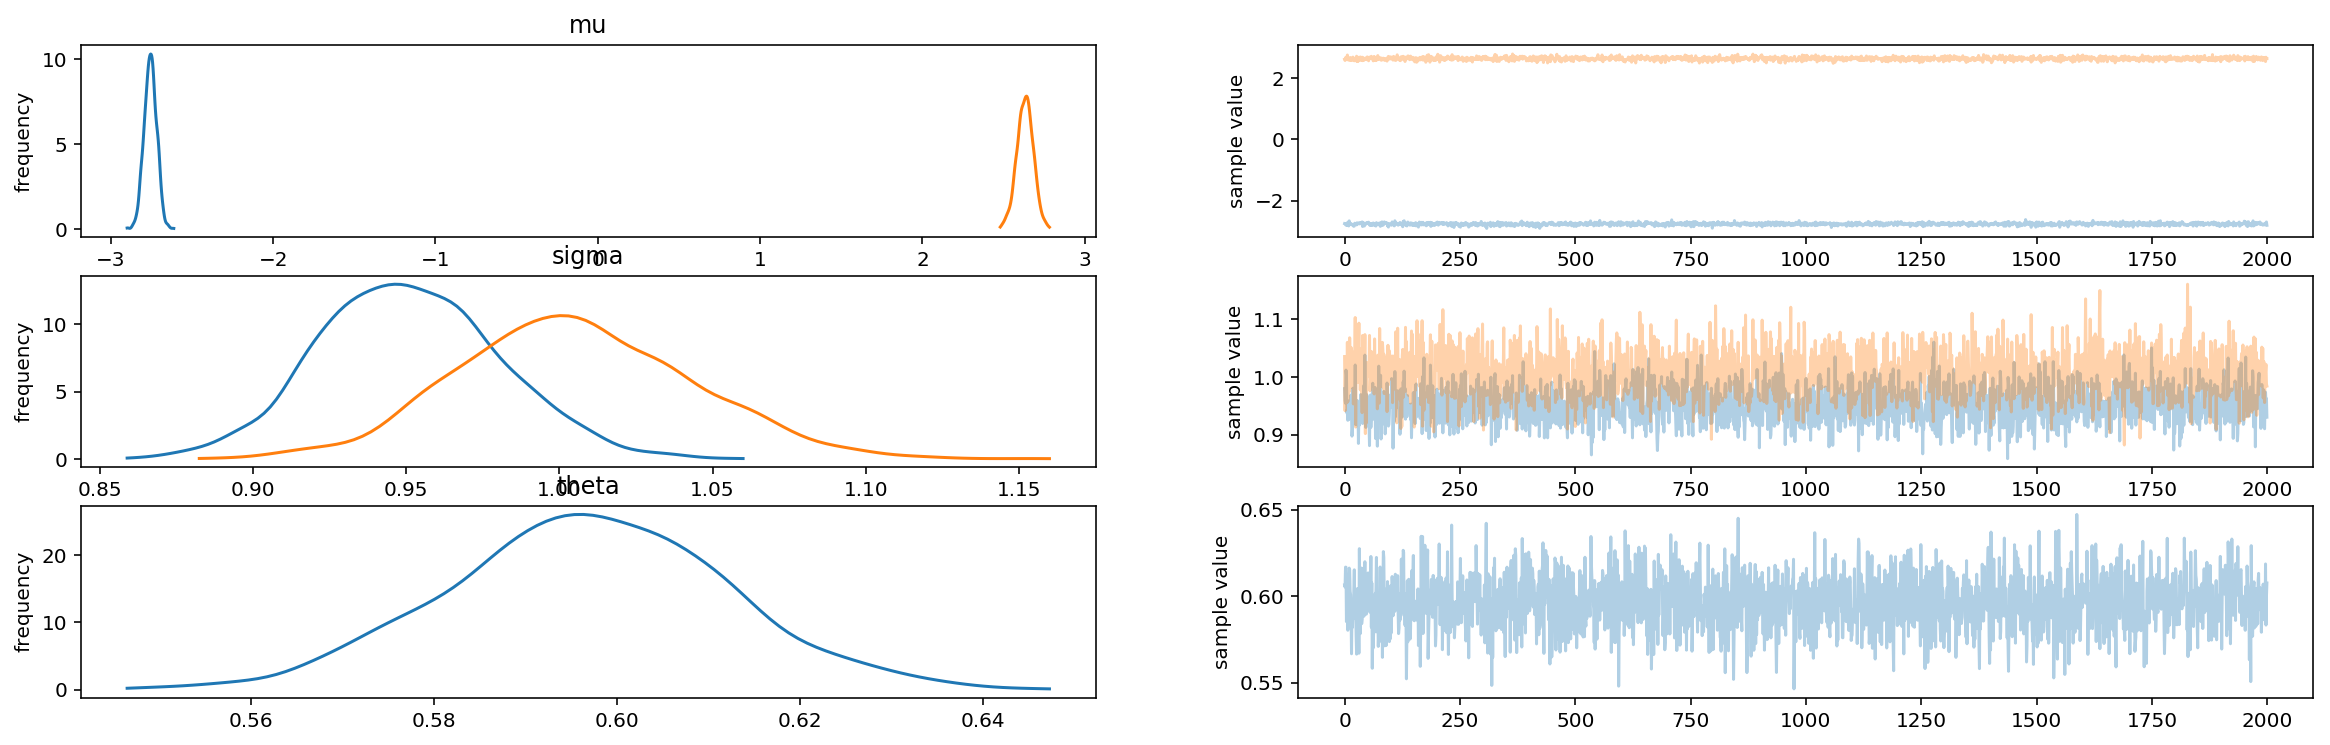

In [5]:
fit = sm.sampling(data=dict(N=len(y), y=y), iter=1000, chains=4)

print(fit)

# if matplotlib is installed (optional, not required), a visual summary and
# traceplot are available
fit.plot()

## θ ~ Dirichlet([5, 5])

http://modernstatisticalworkflow.blogspot.com/2016/10/finite-mixture-models-in-stan.html
https://ecosang.github.io/blog/study/dirichlet-process-with-stan/

In [6]:
model = """
data {
    int<lower = 0> N;
    vector[N] y;
}

parameters {
    ordered[2] mu;
    real<lower=0> sigma[2];
    simplex[2] theta;
}

model {
    sigma ~ normal(0, 2);
    mu ~ normal(0, 2);
    theta ~ dirichlet(rep_vector(2.0, 2));

    // likelihood
    for(i in 1:N) {
        vector[2] contributions;
        for(k in 1:2) {
            contributions[k] = log(theta[k]) + normal_lpdf(y[i] | mu[k], sigma[k]);
        }
        target += log_sum_exp(contributions);
    }
}
"""
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_869aa21d755cb5bb6c3d030321495852 NOW.


/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Inference for Stan model: anon_model_869aa21d755cb5bb6c3d030321495852.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[0]     -2.76  8.6e-4   0.04  -2.83  -2.78  -2.76  -2.73  -2.68   2000    1.0
mu[1]      2.63  1.1e-3   0.05   2.53    2.6   2.63   2.67   2.73   2000    1.0
sigma[0]   0.95  6.5e-4   0.03    0.9   0.93   0.95   0.97   1.01   2000    1.0
sigma[1]   1.01  8.9e-4   0.04   0.93   0.98    1.0   1.03   1.09   2000    1.0
theta[0]    0.6  3.4e-4   0.02   0.57   0.59    0.6   0.61   0.63   2000    1.0
theta[1]    0.4  3.4e-4   0.02   0.37   0.39    0.4   0.41   0.43   2000    1.0
lp__      -2061    0.05   1.58  -2065  -2062  -2060  -2060  -2059    896    1.0

Samples were drawn using NUTS at Fri Aug 17 17:43:07 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction 

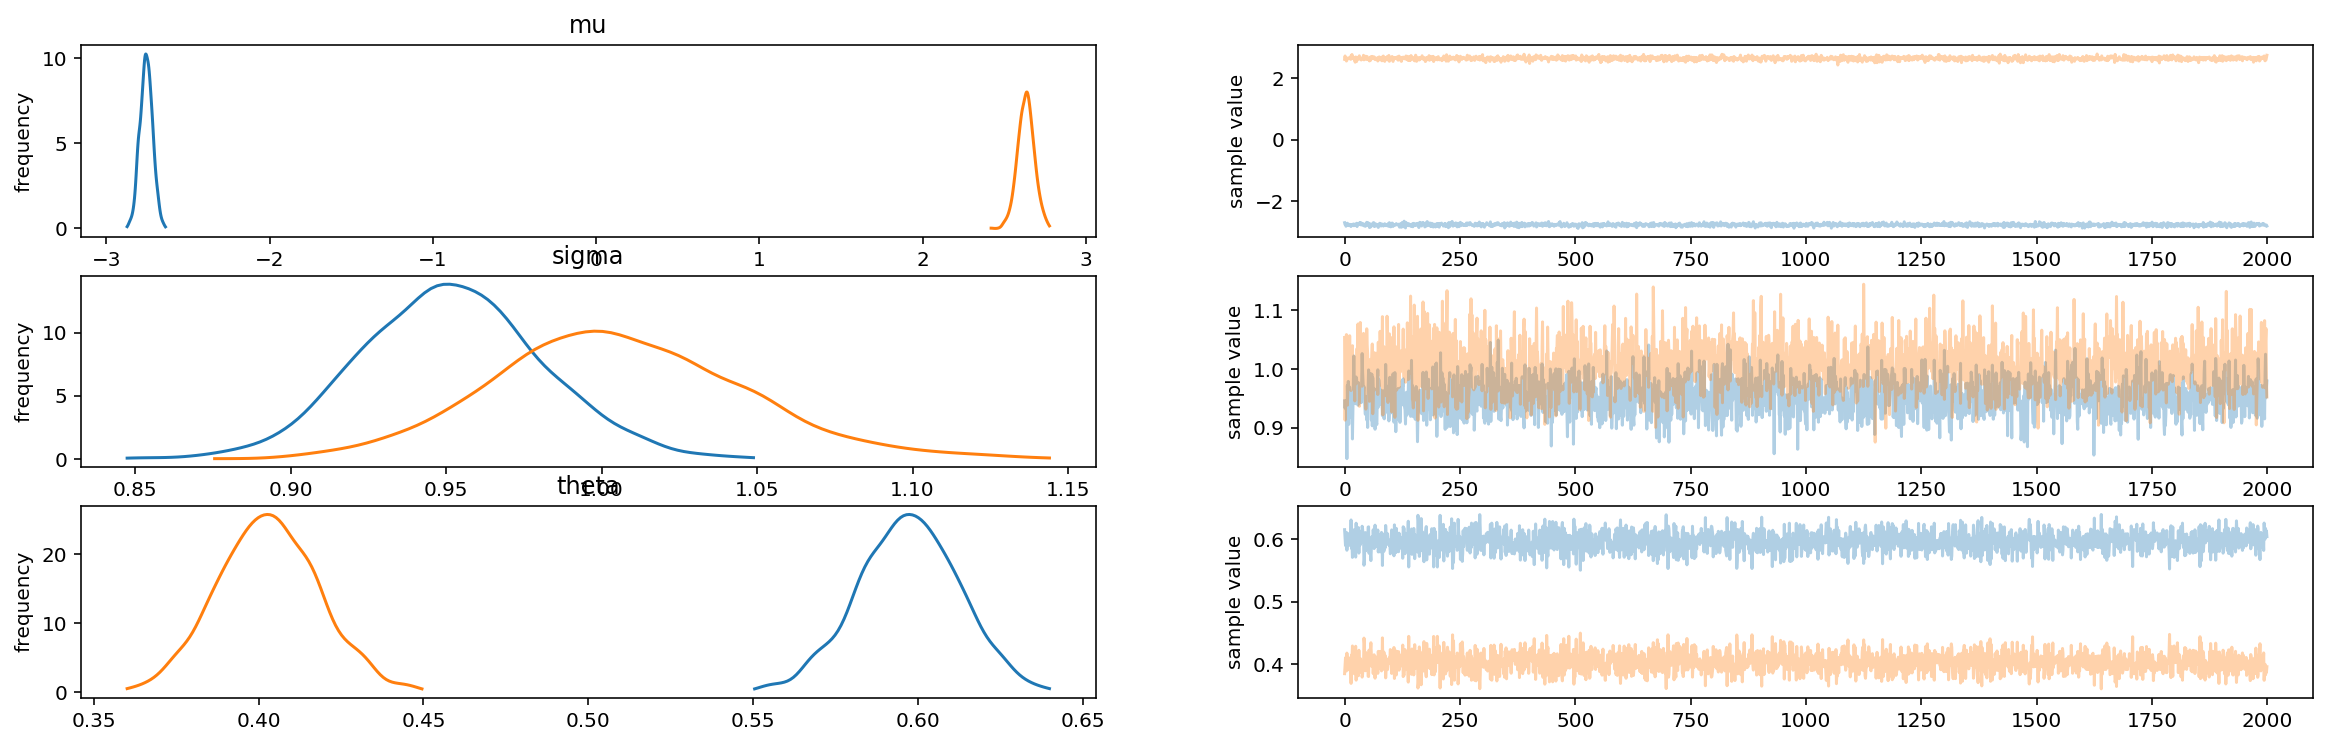

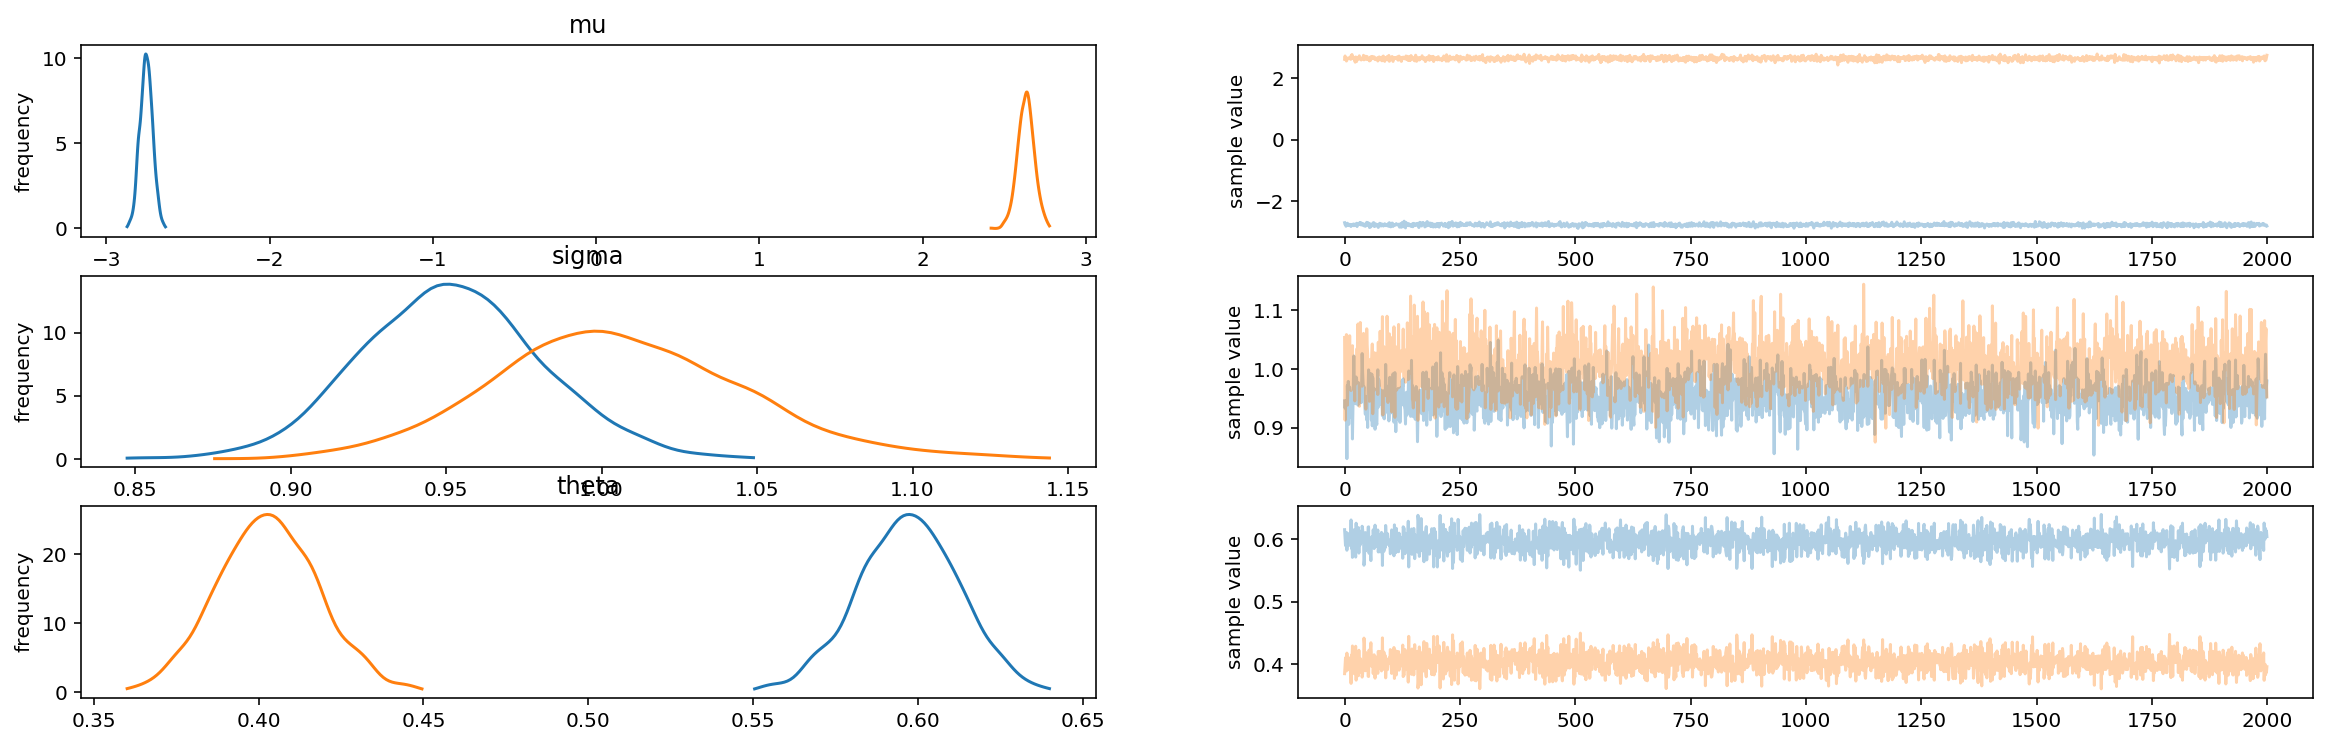

In [7]:
fit = sm.sampling(data=dict(N=len(y), y=y), iter=1000, chains=4)

print(fit)

# if matplotlib is installed (optional, not required), a visual summary and
# traceplot are available
fit.plot()